# Import und Hyperparameter


In [1]:
!pip install -U scikit-learn

     |████████████████████████████████| 6.8MB 20.9MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [2]:
# math
import numpy as np
# tensorflow
%tensorflow_version 2.x
import tensorflow as tf
# visualization
import matplotlib.pyplot as plt
# probabilistic math
import tensorflow_probability as tfp

In [3]:
#hyperparameters
batch_size = 50
#buffer size
buffer_size = 128
#number of epochs to train the network for 
num_epochs = 15
prefetch_size = 32
#learning rate for weight adjustment
learning_rate = 0.001
#optimizer
adam = tf.keras.optimizers.Adam(learning_rate)

# Loading the data set

## Loading `fashion_mnist`

In [4]:
from keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


General information on the `fashion_mnist` dataset can be found here: https://github.com/zalandoresearch/fashion-mnist

The keras documentation (https://keras.io/api/datasets/fashion_mnist/ )provides us with information on the output of the module's `load_data` method: 

>**Returns**>
>
>- Tuple of Numpy arrays: (x_train, y_train), (x_test, y_test).
>- x_train, x_test: uint8 arrays of grayscale image data with shape 
(num_samples, 28, 28).
>- y_train, y_test: uint8 arrays of labels (integers in range 0-9) with shape (num_samples,).




## Previewing the data

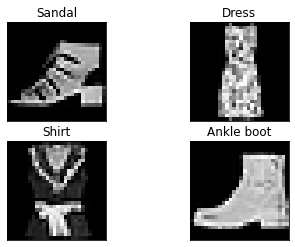

In [5]:
# fashion_mnist labels are integers in range 0-9
# we put the label names in a list in correct order
# (as can be found here https://keras.io/api/datasets/fashion_mnist/)
# so that the integers match the index of the corresponding label name
label_names = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]

# we choose four to be displayed images from the test dataset 
# by randomly determining their indices
a,b,c,d = np.random.randint(low= 0, high= len(x_test)-1, size=4)

fig, axes = plt.subplots(2,2)

axes[0,0].set_title(label_names[y_test[a]])
axes[0,0].imshow(x_test[a],cmap="gray")

axes[0,1].set_title(label_names[y_test[b]])
axes[0,1].imshow(x_test[b],cmap="gray")

axes[1,0].set_title(label_names[y_test[c]])
axes[1,0].imshow(x_test[c],cmap="gray")

axes[1,1].set_title(label_names[y_test[d]])
axes[1,1].imshow(x_test[d],cmap="gray")

for ax in axes.flatten():
    ax.tick_params(left = False, bottom = False, labelleft = False, labelbottom = False)

plt.show()

# Input pipeline and preprocessing

## Normalizing the images

In [6]:
# create normalized images from both data sets

# training images
# normalize
train_images = tf.keras.utils.normalize(x_train)
# add the (redundant) third dimension to the grayscale images to make them compatible with various functions used during training(require dims=4), e.g. for computing the loss
train_images = tf.expand_dims(train_images, axis=3)

# testing images
test_images = tf.keras.utils.normalize(x_test)
test_images = tf.expand_dims(test_images, axis=3)

## Constructing the dataset

In [7]:
# create the testing dataset 
test_dataset_images = tf.data.Dataset.from_tensor_slices(test_images)
test_dataset = tf.data.Dataset.zip((test_dataset_images, test_dataset_images))
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# create the training dataset
train_dataset_images = tf.data.Dataset.from_tensor_slices(train_images)
train_dataset = tf.data.Dataset.zip((train_dataset_images, train_dataset_images))
# batch, shuffle, and prefetch
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.shuffle(buffer_size= buffer_size)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Convolutional Autoencoder

In [8]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Flatten, Reshape
from tensorflow.keras.activations import relu, sigmoid

## Encoder

In [9]:
# reduce featuremap size by subsampling with convolutional layers

class Encoder(tf.keras.layers.Layer):
  
  def __init__(self, embedding_size=10 ):

    super(Encoder, self).__init__()

    # two convolutional layers reduce the feature map size from 28x28 to 7x7
    self.conv_1 = Conv2D(filters= 16,
                         kernel_size= 5,
                         strides=1,
                         padding='same',
                         # the leaky relu has a small non zero derivative for x < 0. That way inactive neurons still get adjusted
                         activation= tf.nn.leaky_relu
                        )


    self.conv_2 = Conv2D(filters=16,
                         kernel_size=3,
                         # increased stride reduces the size of the feature map
                         strides=2,
                         padding='same',
                         activation=tf.nn.leaky_relu
                        )
    
    self.conv_3 = Conv2D(filters= 32,
                         kernel_size= 3,
                         strides= 1,
                         padding= 'same',
                         activation= tf.nn.leaky_relu
                        )

    self.conv_4 = Conv2D(filters=32,
                         kernel_size=3,
                         strides=2,                     
                         padding='same',
                         activation=tf.nn.leaky_relu
                        )
    
    # flatten the feature maps before using a dense layer to create the embedding
    self.flatten = Flatten()
    
    self.dense = Dense(units=embedding_size,
                       activation=relu
                      )
                                                          
  def call(self, input):
    
    x = self.conv_1(input)
    x = self.conv_2(x)
    x = self.conv_3(x)
    x = self.conv_4(x)
    x = self.flatten(x)
    x = self.dense(x)
    
    return x

## Decoder

In [10]:
# increase feature map size using transposed convolution

class Decoder(tf.keras.layers.Layer):
  
  def __init__(self):
    
    super(Decoder, self).__init__()

    # restore dimensionality to the flattened feature maps from the embedding
    self.dense = Dense(
                       units=49,
                       activation=relu
                      )
    
    #reshape the flattened feature maps back into square images
    self.reshape = tf.keras.layers.Reshape((7,7,1))

    # two transposed convolution layers with strides= 2 increase the feature map size from 7x7 back to 28x28
    self.conv_t_1 = Conv2DTranspose(filters=32, 
                                    kernel_size=3, 
                                    strides=2, 
                                    padding='same',
                                    activation= tf.nn.leaky_relu
                                   )
    

    self.conv_t_2 = Conv2DTranspose(filters=32, 
                                    kernel_size=3, 
                                    strides=1, 
                                    padding='same',
                                    activation= tf.nn.leaky_relu
                                   )

    self.conv_t_3 = Conv2DTranspose(
                                    filters= 16, 
                                    kernel_size= 3, 
                                    strides=2, 
                                    padding='same',
                                    activation= tf.nn.leaky_relu
                                   )

    self.conv_t_4 = Conv2DTranspose(
                                    filters= 16, 
                                    kernel_size= 3, 
                                    strides=1, 
                                    padding='same',
                                    activation= tf.nn.leaky_relu
                                   )
    #a bottleneck layer transforms the feature maps back into a single image
    self.bottleneck = Conv2D(
                             filters=1, 
                             kernel_size=3, 
                             padding= 'same', 
                             activation=sigmoid
                            )
                                                        
  def call(self, input):
    x = self.dense(input)
    x = self.reshape(x)
    x = self.conv_t_1(x)
    x = self.conv_t_2(x)
    x = self.conv_t_3(x)
    x = self.conv_t_4(x)
    x = self.bottleneck(x)
    return x


## Autoencoder ## 

Autoencoder, that takes use of the class Encoder to encode an image into the latent space, then decodes a the vector from latent space into image space. 

The dimensionality for the lattent space is  ```embedding_size```.

In [11]:
class Autoencoder(tf.keras.Model):
  def __init__(self, embedding_size):
    """"
      embedding_size (int): Dimensions of latent space
    """
    super(Autoencoder, self).__init__()
    self.encoder = Encoder(embedding_size)
    self.decoder = Decoder()

  def call(self, x):
     x = self.encoder(x)
     x = self.decoder(x)
     return x

# Variational Autoencoder

## Variational Encoder

In [12]:
# reduce featuremap size by subsampling with convolutional layers

class VarEncoder(tf.keras.layers.Layer):
  
  def __init__(self, embedding_size=10, base_depth= 16, num_conv= 3):

    super(VarEncoder, self).__init__()

    self.conv_block_1 = [Conv2D(filters= base_depth, kernel_size= 5, padding='same', activation= tf.nn.leaky_relu) for _ in range(num_conv)]
    
    self.conv_1 = Conv2D(filters= base_depth, 
                         kernel_size= 5, 
                         strides= 2, 
                         padding='same', 
                         activation= tf.nn.leaky_relu)
    
    self.conv_block_2 = [Conv2D(filters= 2*base_depth, kernel_size= 3, padding='same', activation= tf.nn.leaky_relu) for _ in range(num_conv)]
    
    self.conv_2 = Conv2D(filters= 2*base_depth, 
                         kernel_size= 3, strides= 2, 
                         padding='same', 
                         activation= tf.nn.leaky_relu)

    self.flatten = Flatten()
    
    self.dense = Dense(units=tfp.layers.MultivariateNormalTriL.params_size(embedding_size),
                       activation=relu
                      )
    
    self.normal = tfp.layers.MultivariateNormalTriL(
                                                    embedding_size,
                                                    activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=1.0))
                                                          
  def call(self, x):
    for conv in self.conv_block_1:
      x = conv(x)
    x = self.conv_1(x)
    for conv in self.conv_block_2:
      x = conv(x)
    x = self.conv_2(x)
    x = self.flatten(x)
    x = self.dense(x)
    x = self.normal(x)
    
    return x

## Variational Decoder

In [13]:
# increase feature map size using transposed convolution

class VarDecoder(tf.keras.layers.Layer):
  
  def __init__(self, base_depth= 16, num_conv= 3):
    
    super(VarDecoder, self).__init__()

    self.dense = Dense(
                       units=49,
                       activation=relu
                      )
    
    #reshape the flattened feature maps back into square images
    self.reshape = tf.keras.layers.Reshape((7,7,1))

    # two transposed convolution layers increase the feature map size from 7x7 back to 28x28
    self.conv_t_1 = Conv2DTranspose(filters=2*base_depth, 
                                    kernel_size=3, 
                                    strides=2, 
                                    padding='same',
                                    activation= tf.nn.leaky_relu
                                   )
    

    self.conv_t_block_1 = [Conv2DTranspose(filters= 2*base_depth, kernel_size= 3, padding='same', activation= tf.nn.leaky_relu) for _ in range(num_conv)]

    self.conv_t_2 = Conv2DTranspose(
                                    filters= 16, 
                                    kernel_size= 5, 
                                    strides=2, 
                                    padding='same',
                                    activation= tf.nn.leaky_relu
                                   )

    self.conv_t_block_2 = [Conv2DTranspose(filters= base_depth, kernel_size= 5, padding='same', activation= tf.nn.leaky_relu) for _ in range(num_conv)]

    #a bottleneck layer transforms the feature maps back into a single image
    self.bottleneck = Conv2D(
                             filters=1, 
                             kernel_size=3, 
                             padding= 'same', 
                             activation=None
                            )

    self.flatten = Flatten()
    
    self.bernoulli = tfp.layers.IndependentBernoulli((28, 28, 1), tfd.Bernoulli.logits)
                                                        
  def call(self, x):
    x = self.dense(x)
    x = self.reshape(x)
    x = self.conv_t_1(x)
    for conv_t in self.conv_t_block_1:
      x = conv_t(x)
    x = self.conv_t_2(x)
    for conv_t in self.conv_t_block_2:
      x = conv_t(x)
    x = self.bottleneck(x)
    x = self.flatten(x)
    x = self.bernoulli(x)
    return x


## Prior

In [14]:
#prior
# the encoding_size of the prior has to be the same as the embedding_size of the VAE model
tfd = tfp.distributions

encoded_size = 16
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(encoded_size), scale=1),
                        reinterpreted_batch_ndims=1)

## Variational Model ## 
The variational model takes use of the classes for Variational Encoders and Variational Decoders. This works simililarly to the Auto Encoder Model, but the last layer of Encoder and Decoder are respectively propability distributions. 
The dimensionality of the encoding is also regulated via the parameter   ``` embedding_size ```. 

In [15]:
class VarAutoencoder(tf.keras.Model):
  def __init__(self, embedding_size=10, base_depth= 16, num_conv= 3):
    super(VarAutoencoder, self).__init__()
    self.encoder = VarEncoder(embedding_size, base_depth, num_conv)
    self.decoder = VarDecoder(base_depth, num_conv)

  def call(self, x):
     x = self.encoder(x)
     x = self.decoder(x)
     return x

# Training procedure

## Train_step

In [16]:
# We are using a wrapper function for the train_step, because the @tf.function decorater creates a static computational graph
# Which means that we would have to reinitialize this cell every time we want to retrain our model
# Using the wrapper we can create a new static computational graph for every training sequence
def trainer():
  @tf.function
  def train_step(model, input, target, loss_function, optimizer):
    # loss_object and optimizer_object are instances of respective tensorflow classes
    with tf.GradientTape() as tape:
      prediction = model(input, training=True)
      loss = loss_function(target, prediction)
      gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss 
  return train_step

## Train loop

In [17]:
import time
def train(model, loss_func, optimizer):

  running_average_factor = 0.95
  # Initialize lists for later visualization.
  train_losses = []

  # We train for num_epochs epochs.
  for epoch in range(num_epochs):
      start = time.perf_counter()
      
      print('Epoch: __ ' + str(epoch))
      #training (and checking in with training)
      running_average = 0
      ash_ketchum = trainer()
      for (input,target) in train_dataset:
          train_loss = ash_ketchum(model, input, target, loss_func, optimizer)
          running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
      train_losses.append(running_average)

      end = time.perf_counter()
      print(f"time per epoch: {round(end -start, 2)}s, remaining time: {round((end- start) * (num_epochs - epoch - 1), 2)}s")

      ## Visualization of two images

      x = next(iter(test_dataset))[0][0]
      y = next(iter(test_dataset))[0][1]

      fig, axes = plt.subplots(2,2)

      axes[0,0].set_title('original 1')
      axes[0,0].imshow(x[:,:,0],cmap="gray")

      axes[0,1].set_title('original 2')
      axes[0,1].imshow(y[:,:,0],cmap="gray")

      axes[1,0].set_title('reconstructed 1')
      axes[1,0].imshow(model([x])[0,:,:,0],cmap="gray")

      axes[1,1].set_title('reconstructed 2')
      axes[1,1].imshow(model([y])[0,:,:,0],cmap="gray")

      for ax in axes.flatten():
          ax.tick_params(left = False, bottom = False, labelleft = False, labelbottom = False)

      plt.show()

## Training the Conv Autoencoder

Epoch: __ 0

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

time per epoch: 12.61s, remaining time: 176.47s


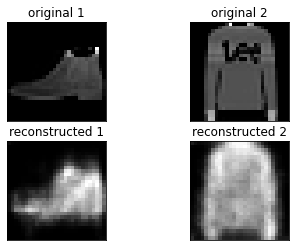

Epoch: __ 1
time per epoch: 5.37s, remaining time: 69.83s


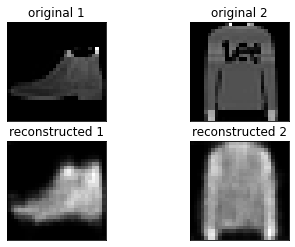

Epoch: __ 2
time per epoch: 4.99s, remaining time: 59.87s


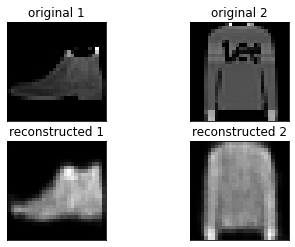

Epoch: __ 3
time per epoch: 5.02s, remaining time: 55.25s


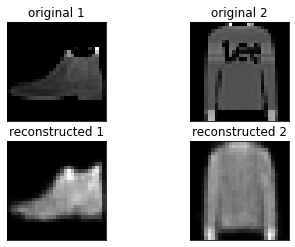

Epoch: __ 4
time per epoch: 5.02s, remaining time: 50.17s


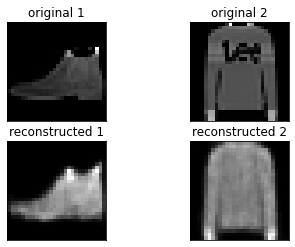

Epoch: __ 5
time per epoch: 5.02s, remaining time: 45.16s


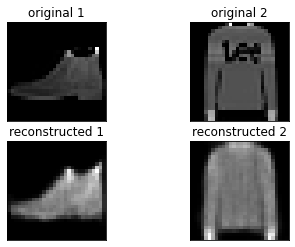

Epoch: __ 6
time per epoch: 5.02s, remaining time: 40.2s


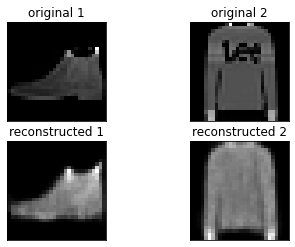

Epoch: __ 7
time per epoch: 5.02s, remaining time: 35.17s


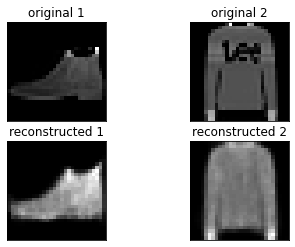

Epoch: __ 8
time per epoch: 5.02s, remaining time: 30.09s


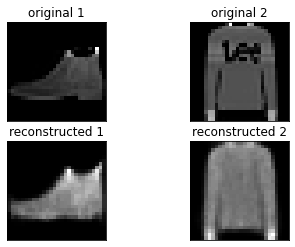

Epoch: __ 9
time per epoch: 5.02s, remaining time: 25.09s


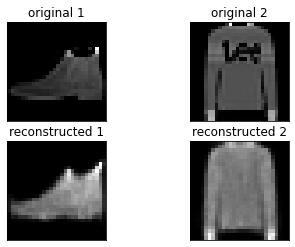

Epoch: __ 10
time per epoch: 5.0s, remaining time: 20.01s


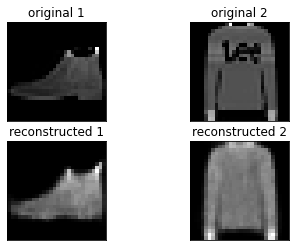

Epoch: __ 11
time per epoch: 5.02s, remaining time: 15.05s


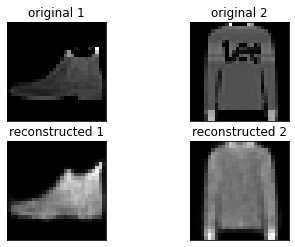

Epoch: __ 12
time per epoch: 4.98s, remaining time: 9.97s


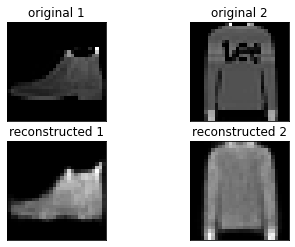

Epoch: __ 13
time per epoch: 5.05s, remaining time: 5.05s


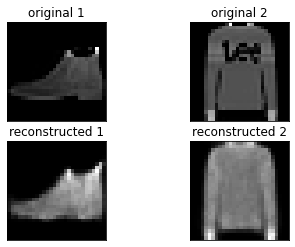

Epoch: __ 14
time per epoch: 5.02s, remaining time: 0.0s


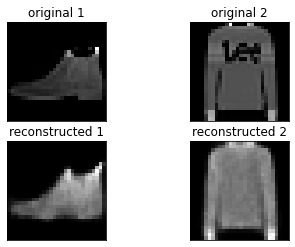

In [18]:
tf.keras.backend.clear_session()

# Initialize the model.
ann = Autoencoder(16)
# Initialize the loss: mean sequared error. Check out 'tf.keras.losses'.
mse = tf.keras.losses.mean_squared_error
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
adam = tf.keras.optimizers.Adam(learning_rate)

train(model= ann, loss_func= mse, optimizer= adam)

## Training the Variational Autoencoder

Epoch: __ 0

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
time per epoch: 12.27s, remaining time: 171.82s


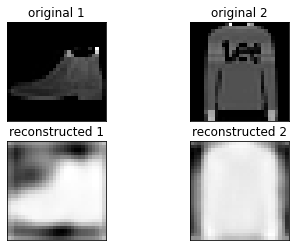

Epoch: __ 1
time per epoch: 11.29s, remaining time: 146.73s


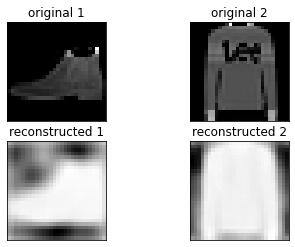

Epoch: __ 2
time per epoch: 11.26s, remaining time: 135.15s


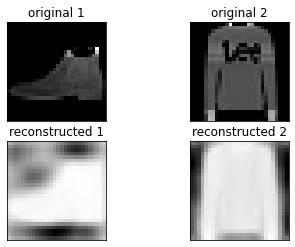

Epoch: __ 3
time per epoch: 11.21s, remaining time: 123.34s


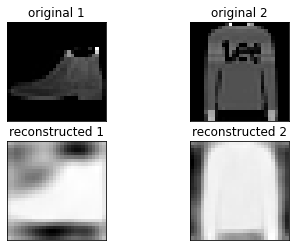

Epoch: __ 4
time per epoch: 11.16s, remaining time: 111.62s


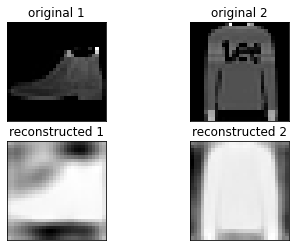

Epoch: __ 5
time per epoch: 11.19s, remaining time: 100.72s


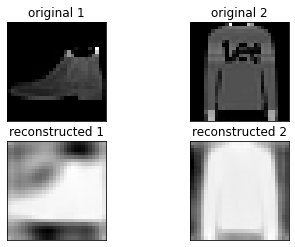

Epoch: __ 6
time per epoch: 11.15s, remaining time: 89.17s


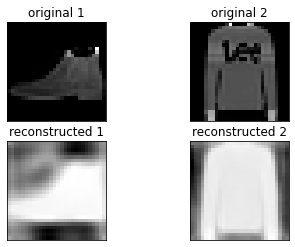

Epoch: __ 7
time per epoch: 11.16s, remaining time: 78.13s


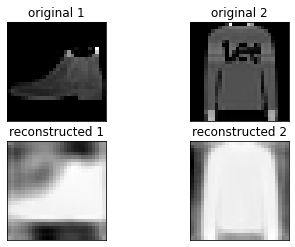

Epoch: __ 8
time per epoch: 11.34s, remaining time: 68.02s


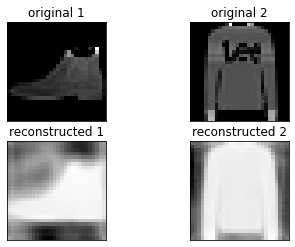

Epoch: __ 9
time per epoch: 11.24s, remaining time: 56.2s


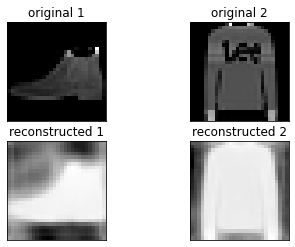

Epoch: __ 10
time per epoch: 11.21s, remaining time: 44.84s


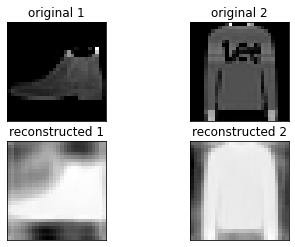

Epoch: __ 11
time per epoch: 11.22s, remaining time: 33.65s


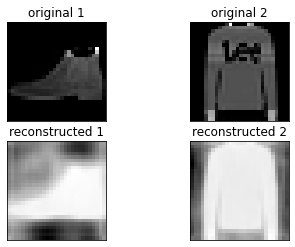

Epoch: __ 12
time per epoch: 11.17s, remaining time: 22.34s


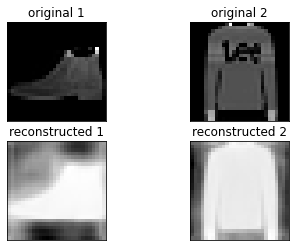

Epoch: __ 13
time per epoch: 11.18s, remaining time: 11.18s


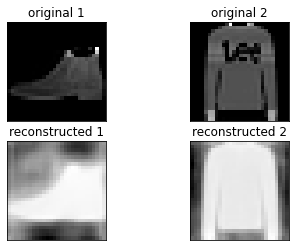

Epoch: __ 14
time per epoch: 11.19s, remaining time: 0.0s


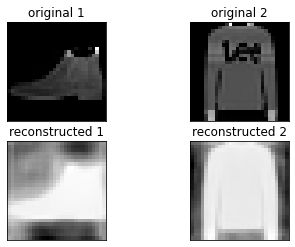

In [19]:
tf.keras.backend.clear_session()
# negative log likelihood is used as the loss function
negloglik = lambda x, rv_x: -rv_x.log_prob(x)
# we initialize the variational autoencoder
vae = VarAutoencoder(embedding_size= 16, base_depth= 16, num_conv= 3)
# the model trains by minimizing the loss using the adam optimizer
train(model= vae, loss_func= negloglik, optimizer= adam)


# Results

## Reconstructed examples

### Convolutional Autoencoder


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



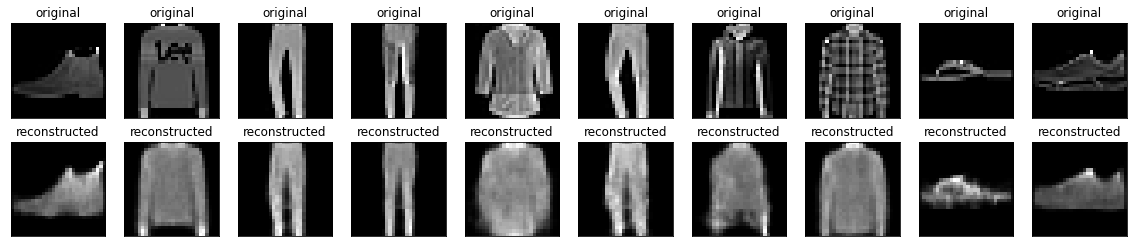

In [20]:
encoded_imgs = ann.encoder(test_images[:1000]).numpy()
decoded_imgs = ann.decoder(encoded_imgs).numpy()

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(test_images[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

plt.show()

Overall the shape seems to be reconstructed quite well, though sharp edges get lost as well as more detailed coloring of the objects. 

### Variational Autoencoder

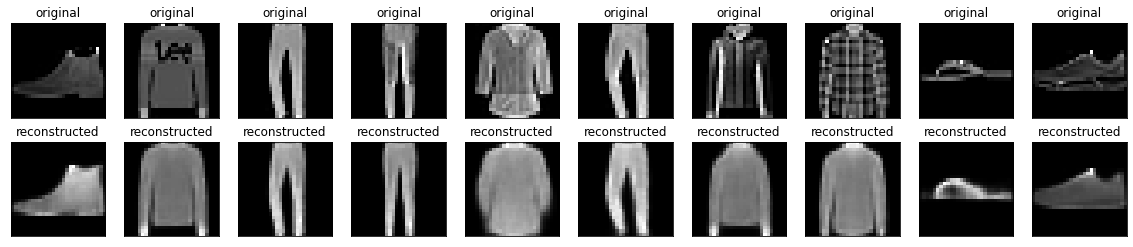

In [21]:
x = next(iter(test_dataset))[0][:10]
xhat = vae(x)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(x[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(xhat.mean()[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

plt.show()

## Linear interpolation 

### Using convolutional Autoencoder

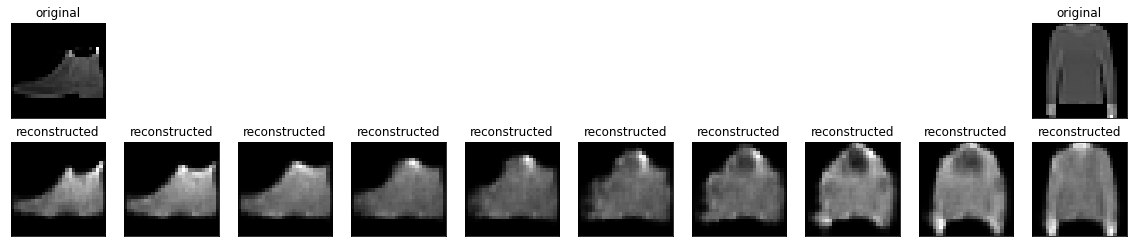

In [22]:
n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    mutant =  (i * encoded_imgs[99] + (10 - i) * encoded_imgs[0])/10
    if (i == 0) | (i == 9):
      # display original
      ax = plt.subplot(2, n, i + 1)
      plt.title("original")
      # dirty workaround to print image 0 and 99
      plt.imshow(tf.squeeze(test_images[11 * i]))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(ann.decoder(np.reshape(mutant, (1,16))).numpy()))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

plt.show()

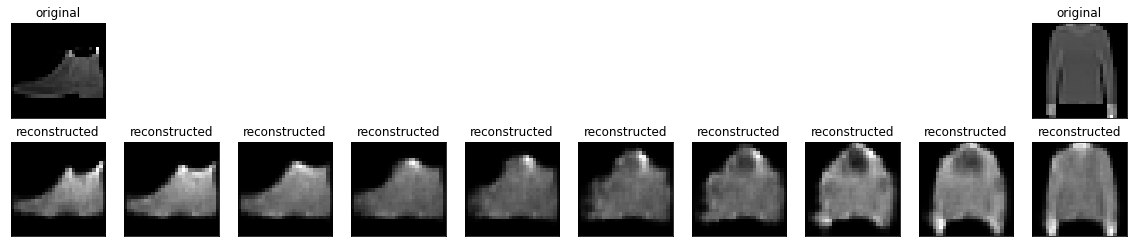

In [23]:
n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    mutant =  (i * encoded_imgs[99] + (10 - i) * encoded_imgs[0])/10
    if (i == 0) | (i == 9):
      # display original
      ax = plt.subplot(2, n, i + 1)
      plt.title("original")
      # dirty workaround to print image 0 and 99
      plt.imshow(tf.squeeze(test_images[11 * i]))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(ann.decoder(np.reshape(mutant, (1,16))).numpy()))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

plt.show()

Shortly before arriving at the pullover/long-sleeve shirt, we seem to pass through a part of the space in which a jacket or coat is encoded, as we can faintly make out a structure similiar to a collar. For the most part the transitional images are not well defined however and some wouldn't even pass as clothing. 

But this is to be expected from a convolutional autoencoder. Since there is no guarantee that a random vector will produce a meaningful image, we might pass through a patch of space devoid of meaningful information as we transition from one class to the other.

### Using variational Autoencoder

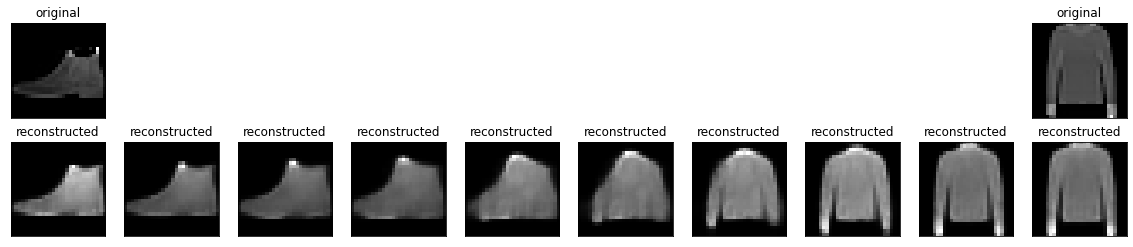

In [30]:
n = 10
plt.figure(figsize=(20, 4))
encoded_sample = vae.encoder(test_images[:100])
for i in range(n):
    mutant =  (i * encoded_sample[99].numpy() + (10 - i) * encoded_sample[0].numpy())/10
    # display original
    if (i == 0) | (i == 9):
      ax = plt.subplot(2, n, i + 1)
      plt.title("original")
      # dirty workaround to print image 0 and 99
      plt.imshow(tf.squeeze(test_images[11 * i]))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(vae.decoder(np.reshape(mutant, (1,16))).mean()))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

plt.show()

With VAE, we try to make it so that any random vector points to a meaningful image. In theory this should allow for "smoother" and faster transitions between classes while reducing our chances of finding noise. We can see here that as the chelsea boot begins to transform, it first turns into a sneaker, then into a bag, and something resembling a hoodie before arriving at the target pullover/long-sleeve shirt. Clearly the locations of the classes within the space have been moved around and separated better. Far fewer of the images could be considered ambiguous.

## Scatterplot color coding by class 

In [25]:
from sklearn.manifold import TSNE
encoded_examples = TSNE(n_components=2).fit_transform(encoded_imgs)

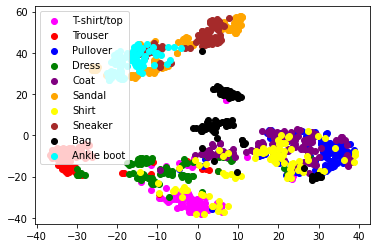

In [26]:
scatter_x = encoded_examples[:,0]
scatter_y = encoded_examples[:,1]
group = y_test[:1000]
cdict = {0: 'magenta', 1: 'red', 2: 'blue', 3: 'green', 4: 'purple', 5: 'orange', 6: 'yellow', 7: 'brown', 8: 'black', 9: 'cyan'}

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = label_names[g])
ax.legend()
plt.show()

There are some expected groupings in the embedded space. Seeing Ankle boots, sandals and sneakers overlapping in the embedded space, makes sense given the similarity of the objects in the low resolution dataset. Since the shape seems to be the dominant intrinsic dimensionality it is however a bit surprising to see bags overlapping with shirts and Pullovers. 

In [27]:
var_encoded_imgs = vae.encoder(test_images[:1000]).mean()
var_encoded_examples = TSNE(n_components=2).fit_transform(var_encoded_imgs)

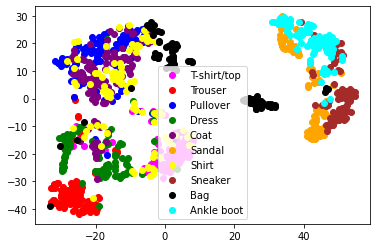

In [28]:
scatter_x = var_encoded_examples[:,0]
scatter_y = var_encoded_examples[:,1]
group = y_test[:1000]
cdict = {0: 'magenta', 1: 'red', 2: 'blue', 3: 'green', 4: 'purple', 5: 'orange', 6: 'yellow', 7: 'brown', 8: 'black', 9: 'cyan'}

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = label_names[g])
ax.legend()
plt.show()

The groupings look similar to the result of the convolutional Autoencoder, but overall the classes seem to be a bit more clearly seperated in the embedded space. We expected the groupings to fill out the space better (i.e. more densely) and to have less overlap than it does since VAE are supposed to do a better job of enforcing location and scale for embeddings. It still appears to be doing a better job than the convolutional autoencoder.